# TP OpenMP - October 2022

Florian Rascoussier

Bastien Barbe

Ce Notebook constitue une étude comparative des méthodes de parallélisation Open MP et SIMD sur CPU pour différentes applications.

## Part 2 : Matrix-Vector operation

Ce programme fait du calcul vectoriel sur des matrices et des vecteurs.

### Compilation

In [23]:
# script params
EXEC: bool = True

In [24]:
# create /bin if it does not exist
!mkdir -p bin

# compile the programs
print("Compilation process:")
print("    + sequential_vector")
!g++ -o bin/tp_openmp_part_2_vector_sequential_vector tp_openmp_part_2_vector_sequential_vector.cpp -fopenmp -O3 -march=native -Wall

print("    + sequential_array")
!g++ -o bin/tp_openmp_part_2_vector_sequential_array tp_openmp_part_2_vector_sequential_array.cpp -fopenmp -O3 -march=native -Wall

print("    + omp_parallel_vector")
!g++ -o bin/tp_openmp_part_2_vector_omp_parallel_vector tp_openmp_part_2_vector_omp_parallel_vector.cpp -fopenmp -O3 -march=native -Wall

print("    + omp_parallel_array")
!g++ -o bin/tp_openmp_part_2_vector_omp_parallel_array tp_openmp_part_2_vector_omp_parallel_array.cpp -fopenmp -O3 -march=native -Wall

print("    + omp SIMD parallel array")
!g++ -o bin/tp_openmp_part_2_vector_omp_simd_parallel_array tp_openmp_part_2_vector_omp_simd_parallel_array.cpp -fopenmp -O3 -march=native -Wall -g


Compilation process:
    + sequential_vector
    + sequential_array
    + omp_parallel_vector
    + omp_parallel_array
    + omp SIMD parallel array


### Performance evaluation

In [25]:
# global vars
csv_result_file = "stats.csv"
csv_headers = {
    'version': str,
    'S': int,
    'runtime' : float
}

matrix_params: list[dict[str, int]] = [
    {"N": 2, "M": 1, "S": 3},
    {"N": 4, "M": 3, "S": 7},
    {"N": 8, "M": 7, "S": 15},
    {"N": 10, "M": 9, "S": 19},
    {"N": 12, "M": 11, "S": 23},
    {"N": 14, "M": 13, "S": 27},
    {"N": 16, "M": 15, "S": 31},
]

color_class = {
    "sequential_vector": "red",
    "sequential_array": "purple",
    "omp_parallel_vector": "blue",
    "omp_parallel_array": "pink",
    "omp_simd_array" : "green",
}

repeats = 10


['sequential_vector', 'sequential_array', 'omp_parallel_vector', 'omp_parallel_array', 'omp_simd_array']


In [26]:
import os
import subprocess

try:
    os.remove(csv_result_file)
except OSError:
    pass

# create csv file
f = open(csv_result_file, "w")
f.write(",".join(csv_headers.keys()) + "\n")
f.close()

# execute the programs
def run_program(program_filepath: str, index: int):
    args = (program_filepath, 
        "-N", str(matrix_params[i]["N"]), 
        "-M", str(matrix_params[i]["M"]),
        "-S", str(matrix_params[i]["S"])
    )
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()
for _ in range(repeats):
    for i in range(0,len(matrix_params)):
        run_program("bin/tp_openmp_part_2_vector_sequential_vector", i)
        run_program("bin/tp_openmp_part_2_vector_sequential_array", i)
        run_program("bin/tp_openmp_part_2_vector_omp_parallel_vector", i)
        run_program("bin/tp_openmp_part_2_vector_omp_parallel_array", i)
        run_program("bin/tp_openmp_part_2_vector_omp_simd_parallel_array", i)


### Performance analysis

,version,S,runtime
0,sequential_vector,8,0.000001
1,sequential_array,8,0.000001
2,omp_parallel_vector,8,0.011538
3,omp_parallel_array,8,0.007894
4,omp_simd_array,8,0.000337
5,sequential_vector,128,0.000002
6,sequential_array,128,0.000002
7,omp_parallel_vector,128,0.007586
8,omp_parallel_array,128,0.000444
9,omp_simd_array,128,0.000438


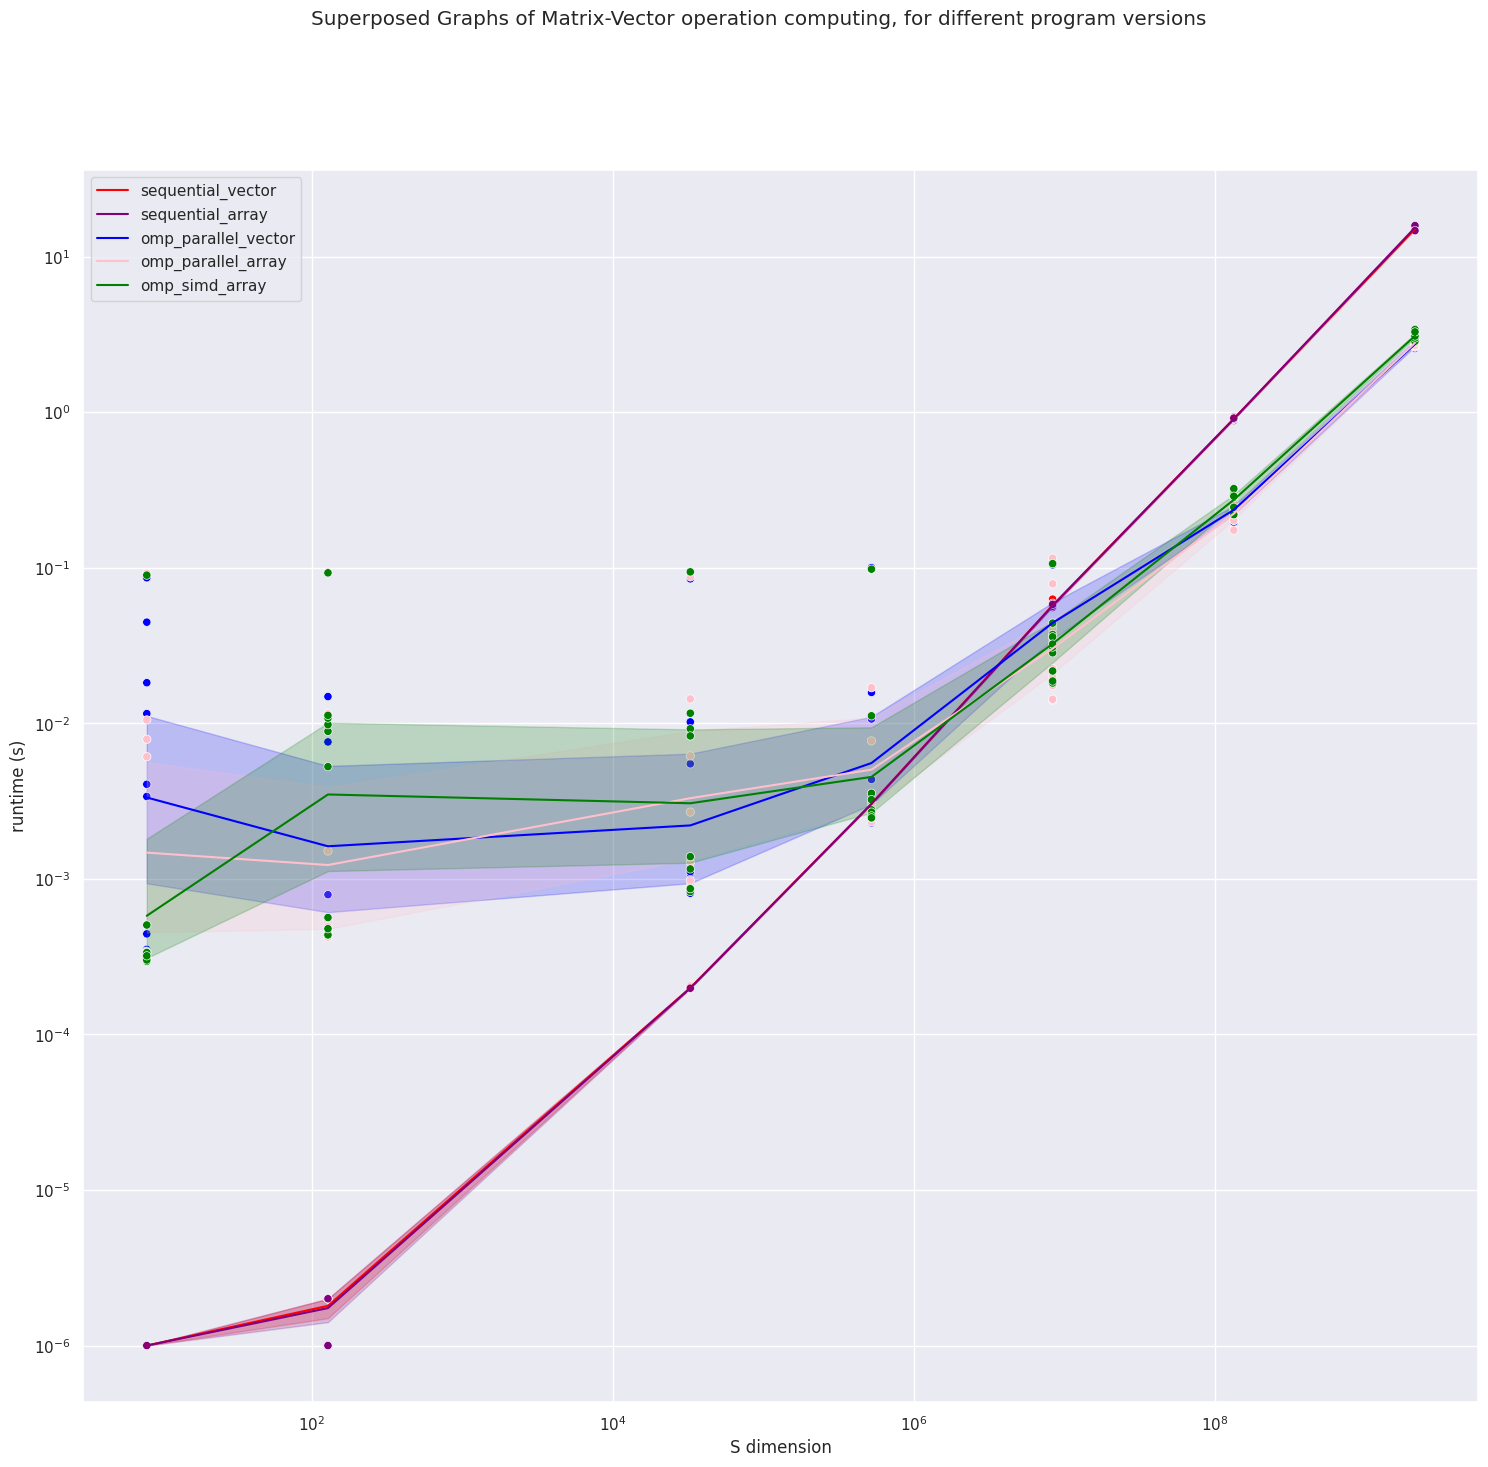

In [30]:
# superposed big graph
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from numpy import genfromtxt
import itertools
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set()


df = pd.read_csv(
    csv_result_file,
    header=0, # line number of header
    dtype=csv_headers
)
display(df.head(10))

# filter out 0 runtime values
df = df[df.runtime > 0]

# display graphs
fig, ax = plt.subplots(figsize=(18,16))
fig.suptitle("Superposed Graphs of Matrix-Vector operation computing, for different program versions")

for i in range(0, len(color_class.keys())):
    # print version graph data
    graph_version = list(color_class.keys())[i]
    df_plot_0 = df[df['version'] == graph_version]

    g0 = sns.lineplot(
        ax=ax,
        data=df_plot_0, 
        x="S",
        y="runtime", 
        hue="version",
        palette=color_class,
        style="version",
    )
    g0.set(xscale="log")
    g0.set(yscale="log")
    g0.set(xlabel="S dimension", ylabel="runtime (s)")
    g00 = sns.scatterplot(
        ax=ax,
        data=df_plot_0, 
        x="S",
        y="runtime", 
        hue="version",
        palette=color_class,
        legend=False,
    )
    g00.set(xscale="log")
    g00.set(yscale="log")


plt.legend()
plt.show()


#### Discussions

On observe que la variabilité des temps de calcul varie beaucoup pour les petites valeurs, mais très faiblement pour les grandes. C'est un résultat attendu.

On note que pour les petites valeurs de S, c'est-à-dire pour un faible nombre de calculs, la version séquentielle est largement la plus rapide. Une inversion s'opère vers S ~= 10^6. À partir de ce niveau, les versions parallèles sont plus rapides. 

On peut tenter d'expliquer ces résultats en se disant que le compilateur `g++` produit déjà un code qui exploite la vectorisation, et ce faisant, qui limite grandement l'intérêt d'ajouter à la main des instructions pour la mettre en place.

Par rapport à la différence de performance entre l'utilisation des vectors face aux arrays de type C, pour nos données, la différence n'est pas significative.